# Word prediction in historical linguistics

## Prerequisites

### Application and data loading
Give a list of languages (from [NorthEuraLex](http://northeuralex.org/languages)) to take under consideration in the `languages` variable. Or set `lang_family` to a language family: `slav` or `ger`. If `lang_family` has been set (not `None`), `languages` will be disregarded.

There is also a variable `cognate_detection`, which is set to `False` by default. This allows multiple forms per concept, which leads to a larger data set. If you would like to be able to perform cognate detection based on prediction results (a later step in this notebook), set this variable to `True`, which restricts the data set to one form per concept.

Other, more specific, options can be set in the file `util/config.py`, before this cell is run.

In [2]:
from util import init
from dataset import data
from util.config import config
import pandas as pd
import sys

lang_family_dict = {
"slav": ["ces", "bul", "rus", "bel", "ukr", "pol", "slk", "slv", "hrv"],
"ger": ["swe", "isl", "eng", "nld", "deu", "dan", "nor"]
}

#--------------------------------------------------------------------
# VARIABLES TO BE SET BY USERv
languages = ["nld","deu", "swe", "isl"]
lang_family = None
cognate_detection = False
#--------------------------------------------------------------------


if lang_family:
    languages = lang_family_dict[lang_family]

    
options, distances_path, baselines_path = init.initialize_program(cognate_detection)
(results_path, output_path_cognates_train, output_path_cognates_valtest,
context_vectors_path, subs_sp_path, subs_st_path, lang_pairs, train, val, test, max_len, 
conversion_key, voc_size, feature_matrix_phon) = data.load_data(train_corpus="northeuralex",
                                                               valtest_corpus="northeuralex",
                                                               languages=languages,  
                                                               input_type="asjp", 
                                                               options=options,
                                                               cognate_detection=False)

Initializing program...


2020-04-10 21:06:58,149 [INFO] Successfully changed parameters.


Loading phonetic feature matrix...
Generating all language pairs...
Training corpus:
 - Loading dataset and performing necessary conversion/tokenization.
Using existing wordlist file, nothing is generated.
 - Detect cognates in entire dataset using LexStat.
Using existing cognates file output/northeuralex-asjp-cognates.tsv, nothing is generated.
Train corpus is valtest corpus.
Loading train/val/test sets from pickle, nothing generated...
Loading train/val/test sets from pickle, nothing generated...
Loading train/val/test sets from pickle, nothing generated...
Loading train/val/test sets from pickle, nothing generated...
Loading train/val/test sets from pickle, nothing generated...
Loading train/val/test sets from pickle, nothing generated...
Loading train/val/test sets from pickle, nothing generated...
Loading train/val/test sets from pickle, nothing generated...
Loading train/val/test sets from pickle, nothing generated...
Loading train/val/test sets from pickle, nothing generated...


### Optional: Enable weight visualization
Run the following cell, to be able to export and visualize the weights of the network. Do this only for diagnostic/visualization purposes, because the batch size will be set to 1, which is not optimal.

In [ ]:
config["export_weights"]=True
config["batch_size"]=1

### Visualize encoding
Visualize the representation of phonemes in the embedding encoding, as PCA and as hierarchically clustered tree. Compare them to the phonetic feature matrix from Brown (2008).

In [ ]:
from dataset import data
from visualize import visualize
from tree import cluster

tree_style = config["ete_tree_style"]

print("Phonetic matrix from Brown (2008):")
# Perform PCA on phonetic feature matrix from Brown (2008)
phon_matrix_red, phon_phonemes = visualize.dim_reduction(feature_matrix_phon)
# Visualize phonetic feature PCA using plot
visualize.visualize_encoding(phon_matrix_red, phon_phonemes, "phonetic-pca")
# Hierarchically cluster distances between phonemes in phonetic feature matrix
tree = cluster.cluster_phonemes_encoding(feature_matrix_phon, phon_phonemes, "phonetic")

display(tree.render("%%inline", tree_style=tree_style))

for lang_pair in lang_pairs:
    lang_a = lang_pair[0]
    print(f"Embedding for {lang_a}:")
    # Create embedding for every first language in language pair
    emb_matrix = data.create_embedding(lang_a, [output_path_cognates_train, output_path_cognates_valtest])
    # Perform PCA on embedding matrix
    emb_matrix_red, emb_phonemes = visualize.dim_reduction(emb_matrix)
    # Visualize embedding PCA using plot
    visualize.visualize_encoding(emb_matrix_red, emb_phonemes, f"embedding-{lang_pair[0]}-pca")
    
    # Hierarchically cluster distances between phonemes in embedding matrix
    tree = cluster.cluster_phonemes_encoding(emb_matrix, emb_phonemes, f"embedding-{lang_pair[0]}")
    display(tree.render("%%inline", tree_style=tree_style))
    

#### Close-up: constrast occurrences of phonemes in data
Interesting patterns in the phoneme encoding visualizations, can be looked up in the data. In the Dutch embedding encoding, we saw that *t* and *d*, closely related phonemes, are quite remote in the embedding space. How do the words with *t* and *d*, on which the embedding encoding is based, look in Dutch?

In [ ]:

lang = "nld"
# Read in TSV file with data
df = pd.read_csv(output_path_cognates_train, sep="\t", engine="python", skipfooter=3, index_col=False)
df_lang = df[df["DOCULECT"] == lang]

for phoneme in ["d", "t"]:
    print(phoneme)
    words_with_phoneme = df_lang[df_lang["ASJP"].str.contains(phoneme)]
    total = len(words_with_phoneme)
    print(f"Total number of occurrences: {total}")
    
    # Compute locations of phonemes in word
    locations = df_lang["ASJP"].str.find(phoneme)
    locations = locations[locations != -1]
    # Compute relative frequencies
    locations_relfreq = locations.value_counts(normalize=True)
    print("Relative frequencies of locations:")
    print(locations_relfreq)
    # Look up words with most frequent location
    most_freq_location = int(locations.mode())
    words_in_most_freq_loc = words_with_phoneme[words_with_phoneme["ASJP"].str.find(phoneme) == most_freq_location]
    print(f"Words with {phoneme} where {phoneme} has most frequent location in word ({most_freq_location}):")
    print(words_in_most_freq_loc)
    print("")
    
    
#words_list = list(df_lang["TOKENS"])




### Show number of cognates in training data
Show the number of cognate word pairs per language pair in the training data, and calculate cliques of languages with a minimum of 100 shared cognates. These cliques can later be used, to have a group of languages with a large shared number of cognates, to perform prediction on.

In [ ]:
cog_per_lang, cliques = data.compute_n_cognates(lang_pairs, output_path_cognates_train, langs=languages, cognates_threshold=100)
print("Cognates per language: ")
print((cog_per_lang))
print("Cliques: ")
for c in cliques:
    print(c)

## Pairwise word prediction

### Word prediction using structured perceptron

In [ ]:
from prediction import prediction

for lang_pair in lang_pairs:
    lang_a, lang_b = lang_pair
    print("Performing structured perceptron word prediction for pair (" + lang_a + ", " + lang_b + ")")
    prediction.word_prediction_seq(lang_a, lang_b, train[lang_pair], val[lang_pair], test[lang_pair], conversion_key[lang_pair], results_path[lang_pair], distances_path + ".txt", config)
        

### Word prediction using encoder-decoder

In [ ]:
from prediction import prediction
for lang_pair in lang_pairs:
    lang_a,lang_b = lang_pair
    print(f"{voc_size[lang_a]} {voc_size[lang_b]}")
    print("Performing RNN word prediction for pair (" + lang_a + ", " + lang_b + ")")
    prediction.word_prediction_rnn(lang_a, lang_b, (max_len[lang_a], max_len[lang_b]), train[lang_pair], val[lang_pair], test[lang_pair], conversion_key[lang_pair], (voc_size[lang_a],voc_size[lang_b]), results_path[lang_pair], distances_path + ".txt", context_vectors_path[lang_pair] + ".p", config["output_encoding"], config)


### Baseline for prediction

In [ ]:
from models import baseline

# Only ASJP
for lang_pair in lang_pairs:
    lang_a,lang_b = lang_pair
    conv = conversion_key[lang_pair]
    sounds = (list(conv[0].values()), list(conv[1].values()))
    training_frame = train[lang_pair].get_dataframe(conversion_key[lang_pair], config["input_encoding"], config["output_encoding"])
    testing_frame = test[lang_pair].get_dataframe(conversion_key[lang_pair], config["input_encoding"], config["output_encoding"])
    baseline.compute_baseline(lang_a, lang_b, sounds, training_frame, testing_frame, baselines_path + ".txt")

### Applications

#### Identify sound correspondences
##### Based on output substitutions
This shows the substitutions table in the notebook, and outputs it as LaTeX table to `RESULTS_DIR/subs.tex`.

In [ ]:
from visualize import visualize

for lang_pair in lang_pairs:
    visualize.show_output_substitutions(results_path[lang_pair], subs_st_path[lang_pair], subs_sp_path[lang_pair])

##### Based on context vector weights (only when weight exported activated)
This works when word prediction with encoder-decoder has been run, and weight export has been activated at the top of this notebook. Executing this command shows the distances between input, output and context vectors. Furthermore, it generates PCA plots of the input, output and context vectors and generates LaTeX files.

In [ ]:
from visualize import visualize

for lang_pair in lang_pairs:
    visualize.visualize_weights(context_vectors_path[lang_pair], lang_pair, config["input_encoding"], config["output_encoding"], config["results_dir"], sample=None)


#### Phylogenetic tree reconstruction

##### Clustering based on word prediction

 - Creating tree using UPGMA, saving to .nw and .pdf
 - Creating tree using Neighbour joining, saving to .nw and .pdf
Mean distance of all lang pairs: 0.5193


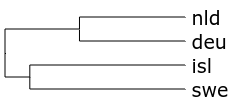

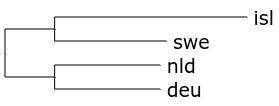

In [3]:
from tree import cluster

# Cluster based on word prediction distances
trees = cluster.cluster_languages(lang_pairs, distances_path, output_path=distances_path)

# Show trees in notebook
for tree in trees:
    display(tree.render("%%inline",tree_style=config["ete_tree_style"]))

##### Clustering based on baseline

In [ ]:
from tree import cluster

# Source prediction baseline
print("\nSOURCE BASELINE TREE")
cluster.cluster_languages(lang_pairs, baselines_path, output_path=baselines_path + "_source", distance_col=2)
# PMI-based baseline
print("\nPMI BASELINE TREE")
cluster.cluster_languages(lang_pairs, baselines_path, output_path=baselines_path + "_pmi", distance_col=3)

##### Draw tree from existing newick string (no distance calculcation)

In [ ]:
####Improvised code to re-generate trees
from ete3 import Tree, TreeStyle, NodeStyle, TextFace
from scipy.spatial.distance import pdist, squareform
newick_string1 = "((bul:0.15,(slv:0.11,hrv:0.11):0.04):0.04,((rus:0.11,(bel:0.1,ukr:0.1):0.01):0.07,(pol:0.15,(ces:0.08,slk:0.08):0.07):0.03):0.01);"
newick_string2 = "(((bel:0.08,ukr:0.12):0.01,rus:0.12):0.03,(((slv:0.1,hrv:0.11):0.01,bul:0.18):0.07,(pol:0.17,(ces:0.1,slk:0.07):0.05):0.04):0.03);"
newick_string3 = "((bul:0.29,((ces:0.24,slk:0.24):0.04,(slv:0.25,hrv:0.25):0.03):0.01):0.01,(pol:0.28,(rus:0.24,(bel:0.22,ukr:0.22):0.02):0.04):0.01);"
newick_string4 = "((bel,rus,ukr),((hrv,slv),bul),((ces,slk),pol));"

ts = TreeStyle()
ts.show_scale = False
ts.show_leaf_name = False
ts.force_topology = False
ts.show_border = False
ts.margin_top = ts.margin_bottom = ts.margin_right = ts.margin_left = 5
ts.scale = 500
ts.branch_vertical_margin= 10


for i,newick_string in enumerate([newick_string1, newick_string2, newick_string3, newick_string4]):
    if i==3: # last newick string without lengths, should be corrected
        ts = TreeStyle()
        ts.show_scale = False
        ts.show_leaf_name = False
        ts.force_topology = False
        ts.show_border = False
        ts.margin_top = ts.margin_bottom = ts.margin_right = ts.margin_left = 5
        ts.scale = 50
        ts.branch_vertical_margin= 10
    # Load newick string into ete3 Tree object
    tree = Tree(newick_string)
    for node in tree.traverse():
        node.set_style(config["ete_node_style"])
        if node.is_leaf():
            # Add bit of extra space between leaf branch and leaf label
            name_face = TextFace(f" {node.name}", fgcolor="black", fsize=10)
            node.add_face(name_face, column=0, position='branch-right')
    print(f"output/tree{i+1}.pdf")
    tree.render(f"output/tree{i+1}.pdf", tree_style=ts)
    display(tree.render(f"%%inline", tree_style=ts))

#### Cognate detection

In [ ]:
from cognatedetection import cd

### TODO: this part from previous code should not be executed:
# print("Filter val/test sets on cognates.")
# Use only cognate pairs for validation and test
# val[lang_pair] = val[lang_pair].filter_cognates()
# test[lang_pair] = test[lang_pair].filter_cognates()
# print("Val/test sizes after cognate filtering: " + str(val[lang_pair].get_size()) + "|" + str(test[lang_pair].get_size()))


print("Performing WP cognate detection using clustering...")
results_table = cd.cognate_detection_cluster(lang_pairs, config["results_dir"], options, use_distance="prediction")
print(results_table)